### Variable descriptions of original data set
|Item|Name|Description|
|:--:|:--|:--|
|1|	Year	|1987-2008|
|2|	Month	|1-12|
|3|	DayofMonth	|1-31|
|4|	DayOfWeek	|1 (Monday) - 7 (Sunday)|
|5|	DepTime	|actual departure time (local, hhmm)|
|6|	CRSDepTime	|scheduled departure time (local, hhmm)|
|7|	ArrTime	actual |arrival time (local, hhmm)|
|8|	CRSArrTime	|scheduled arrival time (local, hhmm)|
|9|	UniqueCarrier	|unique carrier code|
|10|	FlightNum	|flight number|
|11|	TailNum	plane |tail number|
|12|	ActualElapsedTime	|in minutes|
|13|	CRSElapsedTime	|in minutes|
|14|	AirTime	|in minutes|
|15|	ArrDelay	|arrival delay, in minutes|
|16|	DepDelay	|departure delay, in minutes|
|17|	Origin	|origin IATA airport code|
|18|	Dest	|destination IATA airport code|
|19|	Distance	|in miles|
|20|	TaxiIn	|taxi in time, in minutes|
|21|	TaxiOut	|taxi out time in minutes|
|22|	Cancelled	|was the flight cancelled?|
|23|	CancellationCode	|reason for cancellation (A = carrier, B = weather, C = NAS, D = security)|
|24|	Diverted	|1 = yes, 0 = no|
|25|	CarrierDelay	|in minutes|
|26|	WeatherDelay	|in minutes|
|27|	NASDelay	|in minutes|
|28|	SecurityDelay	|in minutes|
|29|	LateAircraftDelay	|in minutes|

In [1]:
# general stuff
import locale
locale.setlocale(locale.LC_ALL, 'en_US')

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('compute.use_bottleneck', True)
pd.set_option('compute.use_numexpr', True)

import os

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


import dask.dataframe as dd
from dask import compute, persist
from dask.distributed import Client, progress

!pwd

/Users/mattbaldree/Google Drive/smu/quantifying/QTW_14/QTW_14


In [2]:
# flags

PURGE_DATA = True

In [3]:
# start Dask distributed client and print out stats

c = Client()
c

Client Scheduler: tcp://127.0.0.1:50358 Dashboard: http://127.0.0.1:8787,Cluster Workers: 4 Cores: 4 Memory: 10.31 GB


In [4]:
# if loading data, then purge existing data directory.

if PURGE_DATA:
    # delete /data directory
    from shutil import rmtree

    path = 'data'
    if os.path.exists(path):
        rmtree(path)
    
    # make /data if it doesn't exist
    path = 'data'
    if not os.path.exists(path):
        os.mkdir(path)

In [5]:
# if loading data, download files and decompress them in parallel.

DOWNLOAD_ONE_FILE_ONLY = True

if PURGE_DATA:
    import urllib.request
    import shutil
    import bz2
    
    def download_file(baseurl, yr):
        file_name = ''

        url_of_data_file = baseurl%(yr)
        file_name = 'data/%d.csv'%(yr)
        size = 0

        print('downloading', url_of_data_file, 'to', file_name)
        decompressor = bz2.BZ2Decompressor()

        # download file and decompress it
        with urllib.request.urlopen(url_of_data_file) as response, open(file_name, 'wb') as out_file:
                data = decompressor.decompress(response.read())
                out_file.write(data)
                size = len(data)
                print('file size (MB)', locale.format('%.1f', size/1000000, grouping=True))

        return(file_name, size)
    
    def print_files(files):
        totalSize = 0        
        for f in files:
            size = f[1]/1000000
            totalSize += size
            print('downloaded file:', f[0], ', of size (MB):', 
                  locale.format('%.1f', size, grouping=True))
            
        print('Number of files downloaded:', len(files), 'for a total size (MB):', 
              locale.format('%.1f', totalSize, grouping=True))


    if DOWNLOAD_ONE_FILE_ONLY:
        # testing
        download_file('http://stat-computing.org/dataexpo/2009/%d.csv.bz2', 1987)
    else:    
        # download airline data from 1987 to 2009
        yrs = range(1987, 2009)
        baseurl = 'http://stat-computing.org/dataexpo/2009/%d.csv.bz2'

        from dask import delayed
        download_file = delayed(download_file)

        files = [download_file(baseurl, yr) for yr in yrs]
        files = delayed(files)

        %time files = files.compute()   
      
        print_files(files)

downloading http://stat-computing.org/dataexpo/2009/1987.csv.bz2 to data/1987.csv
file size (MB) 127.2


**Click on Dashboard URL printed out above to see the distributed work.**

In [6]:
# print the head of a csv file

print('csv file format')
!head data/1987.csv

csv file format
Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1987,10,14,3,741,730,912,849,PS,1451,NA,91,79,NA,23,11,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,15,4,729,730,903,849,PS,1451,NA,94,79,NA,14,-1,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,17,6,741,730,918,849,PS,1451,NA,97,79,NA,29,11,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,18,7,729,730,847,849,PS,1451,NA,78,79,NA,-2,-1,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,19,1,749,730,922,849,PS,1451,NA,93,79,NA,33,19,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,21,3,728,730,848,849,PS,1451,NA,80,79,NA,-1,-2,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,22,4,728,730,852,849,PS,1451,NA,84,79,NA,3,-2,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,23,5,731,730

In [7]:
# load csv files into a dataframe in parallel

filename = os.path.join('data', '*.csv')
print('Loading', filename, 'files')

import dask.dataframe as dd
%time df_csv = dd.read_csv(filename, assume_missing=True, \
                           dtype={'TailNum':np.object, 'CancellationCode':np.object}, \
                           storage_options={'anon': True}).rename(columns=str.lower)

print(df_csv.dtypes)
df_csv.head()

Loading data/*.csv files
CPU times: user 41.1 ms, sys: 14 ms, total: 55.1 ms
Wall time: 58.7 ms
year                 float64
month                float64
dayofmonth           float64
dayofweek            float64
deptime              float64
crsdeptime           float64
arrtime              float64
crsarrtime           float64
uniquecarrier         object
flightnum            float64
tailnum               object
actualelapsedtime    float64
crselapsedtime       float64
airtime              float64
arrdelay             float64
depdelay             float64
origin                object
dest                  object
distance             float64
taxiin               float64
taxiout              float64
cancelled            float64
cancellationcode      object
diverted             float64
carrierdelay         float64
weatherdelay         float64
nasdelay             float64
securitydelay        float64
lateaircraftdelay    float64
dtype: object


,year,month,dayofmonth,dayofweek,deptime,crsdeptime,arrtime,crsarrtime,uniquecarrier,flightnum,tailnum,actualelapsedtime,crselapsedtime,airtime,arrdelay,depdelay,origin,dest,distance,taxiin,taxiout,cancelled,cancellationcode,diverted,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
0,1987.0,10.0,14.0,3.0,741.0,730.0,912.0,849.0,PS,1451.0,NaN,91.0,79.0,NaN,23.0,11.0,SAN,SFO,447.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,1987.0,10.0,15.0,4.0,729.0,730.0,903.0,849.0,PS,1451.0,NaN,94.0,79.0,NaN,14.0,-1.0,SAN,SFO,447.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,1987.0,10.0,17.0,6.0,741.0,730.0,918.0,849.0,PS,1451.0,NaN,97.0,79.0,NaN,29.0,11.0,SAN,SFO,447.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,1987.0,10.0,18.0,7.0,729.0,730.0,847.0,849.0,PS,1451.0,NaN,78.0,79.0,NaN,-2.0,-1.0,SAN,SFO,447.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,1987.0,10.0,19.0,1.0,749.0,730.0,922.0,849.0,PS,1451.0,NaN,93.0,79.0,NaN,33.0,19.0,SAN,SFO,447.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [8]:
# drop columns we don't need or want
df_csv = df_csv.drop(['tailnum', 'actualelapsedtime', 'crselapsedtime', 'airtime', \
             'taxiin', 'taxiout', 'cancelled', 'cancellationcode', \
             'diverted', 'carrierdelay', 'weatherdelay', 'nasdelay', \
             'securitydelay', 'lateaircraftdelay'], axis=1)

In [9]:
# categorize appropriate columns

object_columns = ['uniquecarrier', 'origin', 'dest', 'year', 'month', 'dayofmonth', 'dayofweek']
for i in object_columns:
    df_csv[i] = df_csv[i].astype('category')

df_csv = df_csv.categorize()

In [10]:
df_csv.dtypes

year             category
month            category
dayofmonth       category
dayofweek        category
deptime           float64
crsdeptime        float64
arrtime           float64
crsarrtime        float64
uniquecarrier    category
flightnum         float64
arrdelay          float64
depdelay          float64
origin           category
dest             category
distance          float64
dtype: object

In [11]:
# shape of dataframe

number_of_items = len(df_csv)
locale.format('%d', number_of_items, grouping=True)

'1,311,826'

Top origin airports
ORD    67216
ATL    66309
DFW    51860
LAX    45646
DEN    43376
SFO    35155
STL    32097
EWR    30991
PHX    29848
PIT    28765
Name: origin, dtype: int64


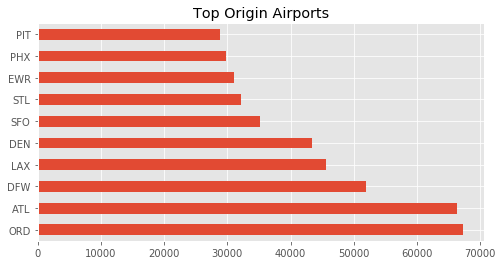

In [12]:
# Top 10 origin airports

origin_counts = df_csv.origin.value_counts().head(10)
print('Top origin airports')
print(origin_counts)

origin_counts.plot(kind='barh', figsize=(8,4), title='Top Origin Airports')

## Q1. What airports have the most delayed departures and arrivals?

A flight is delayed if it leaves or arrives more than 15 minutes after its scheduled time.

In [ ]:
# Filter departure flights

df_delayed_departure = df_csv[df_csv.depdelay > 15]
delayed_counts = df_delayed_departure.origin.value_counts().head(10)
print('Top delayed origin airports')
print(delayed_counts)

delayed_counts.plot(kind='barh', figsize=(8,4), title='Top Delayed Origin Airports')

In [ ]:
# Filter arrival flights

df_delayed_arrival = df_csv[df_csv.arrdelay > 15]
delayed_counts = df_delayed_arrival.dest.value_counts().head(10)
print('Top delayed destination airports')
print(delayed_counts)

delayed_counts.plot(kind='barh', figsize=(8,4), title='Top Delayed Destination Airports')

## Q2. What flights are most frequently delayed with same origin and destination?

A flight is delayed if it leaves or arrives more than 15 minutes after its scheduled time.

In [ ]:
# Filter the dataset to delayed flights

df_filtered = df_csv.loc[(df_csv.arrdelay > 15) or (df_csv.depdelay > 15)].compute()
df_filtered.head()

In [ ]:
# Group filtered dataset by origin, dest, and flightnum

grp = df_filtered.groupby(['origin', 'dest', 'flightnum']) \
.flightnum.count().reset_index(name='count').sort_values(['count'], ascending=False)

grp.head(15)

In [ ]:
# Plot results

grp.head(15).set_index('flightnum').plot(kind='barh', figsize=(8,4), \
                                         title='Top Delayed Flights with Same Origin and Destination Airports')

## Q3. Can you predict a flight's delayed minutes?

Create a prediction model to predict flight delays. Dependent features like weather were not added because you don't know the weather accurately for the day. A new feature was added named `hdays` to indicate how many days the flight was from a holiday. Holidays have a significant impact on travel. Other key features might be helpful, but time did not permit further exploration.

The work is borrowed from `https://jessesw.com/Air-Delays/`,  `https://gist.github.com/mrocklin/19c89d78e34437e061876a9872f4d2df`, and `https://github.com/dmlc/xgboost/blob/master/demo/guide-python/sklearn_examples.py`.

In [13]:
# Function to determine the difference between flight date and neares holiday.
# see https://jessesw.com/Air-Delays/

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='1987-01-01', end='2008-12-31').to_pydatetime()

from datetime import date, datetime, timedelta

def days_until_holiday(d):
    ans = timedelta(100000)
    for i in range(len(holidays)):
        candidate = abs(holidays[i]-d)
        if candidate < ans:
            ans = candidate
    return(float(ans.days))

#assert(days_until_holiday(datetime(2001, 1, 1))==0)
#assert(days_until_holiday(datetime(2009, 1, 1))==7)

In [ ]:
# Using apply is slow. Need to see if there is a faster way.

# create days from nearest holiday column
df_csv['hdays'] = df_csv.apply(lambda r: days_until_holiday(datetime(int(r.year), int(r.month), int(r.dayofmonth))),
                               meta=float, axis=1)
df_csv.head()

In [14]:
# drop columns we don't need or want
df_csv = df_csv.drop(['deptime', 'arrtime', 'flightnum'], axis=1)

In [15]:
df_csv.dtypes

year             category
month            category
dayofmonth       category
dayofweek        category
crsdeptime        float64
crsarrtime        float64
uniquecarrier    category
arrdelay          float64
depdelay          float64
origin           category
dest             category
distance          float64
dtype: object

In [16]:
# random sample of data (features)
df = df_csv.sample(frac=0.2)

# drop rows with NaN
prev_count = len(df)
df = df.dropna()
number_of_items = len(df)
print('dropped %s percent of rows with NA' % locale.format('%.2f', prev_count/number_of_items))

# target data
y = df.depdelay

df = df.drop(['depdelay'], axis=1)

df, y = persist(df, y)
progress(df, y)

dropped 1.02 percent of rows with NA


In [17]:
df.head()

,year,month,dayofmonth,dayofweek,crsdeptime,crsarrtime,uniquecarrier,arrdelay,origin,dest,distance
24086,1987.0,10.0,16.0,5.0,1643.0,1640.0,TW,2.0,SDF,STL,254.0
582359,1987.0,11.0,16.0,1.0,2115.0,2305.0,HP,-2.0,DEN,PHX,602.0
238542,1987.0,10.0,17.0,6.0,1535.0,1635.0,CO,-17.0,DEN,GJT,212.0
76027,1987.0,10.0,7.0,3.0,730.0,838.0,UA,17.0,LGA,IAD,229.0
326566,1987.0,10.0,13.0,2.0,1000.0,1148.0,EA,20.0,ORF,MCO,655.0


In [18]:
y.head()

24086     0.0
582359    8.0
238542   -1.0
76027    -3.0
326566    0.0
Name: depdelay, dtype: float64

## One hot encode

In [19]:
X = dd.get_dummies(df.categorize())

In [20]:
X.describe().compute()

,crsdeptime,crsarrtime,arrdelay,distance,year_1987.0,month_10.0,month_11.0,month_12.0,dayofmonth_1.0,dayofmonth_2.0,dayofmonth_3.0,dayofmonth_4.0,dayofmonth_5.0,dayofmonth_6.0,dayofmonth_7.0,dayofmonth_8.0,dayofmonth_9.0,dayofmonth_10.0,dayofmonth_11.0,dayofmonth_12.0,dayofmonth_13.0,dayofmonth_14.0,dayofmonth_15.0,dayofmonth_16.0,dayofmonth_17.0,dayofmonth_18.0,dayofmonth_19.0,dayofmonth_20.0,dayofmonth_21.0,dayofmonth_22.0,dayofmonth_23.0,dayofmonth_24.0,dayofmonth_25.0,dayofmonth_26.0,dayofmonth_27.0,dayofmonth_28.0,dayofmonth_29.0,dayofmonth_30.0,dayofmonth_31.0,dayofweek_1.0,dayofweek_2.0,dayofweek_3.0,dayofweek_4.0,dayofweek_5.0,dayofweek_6.0,dayofweek_7.0,uniquecarrier_AA,uniquecarrier_AS,uniquecarrier_CO,uniquecarrier_DL,uniquecarrier_EA,uniquecarrier_HP,uniquecarrier_NW,uniquecarrier_PA (1),uniquecarrier_PI,uniquecarrier_PS,uniquecarrier_TW,uniquecarrier_UA,uniquecarrier_US,uniquecarrier_WN,origin_ABE,origin_ABQ,origin_ACV,origin_AGS,origin_ALB,origin_ALO,origin_AMA,origin_ANC,origin_APF,origin_ATL,origin_ATW,origin_AUS,origin_AVL,origin_AVP,origin_AZO,origin_BDL,origin_BET,origin_BFL,origin_BGM,origin_BGR,origin_BHM,origin_BIL,origin_BIS,origin_BLI,origin_BNA,origin_BOI,origin_BOS,origin_BTM,origin_BTR,origin_BTV,origin_BUF,origin_BUR,origin_BWI,origin_BZN,origin_CAE,origin_CAK,origin_CCR,origin_CDV,origin_CHA,origin_CHO,origin_CHS,origin_CID,origin_CLE,origin_CLT,origin_CMH,origin_CMI,origin_COS,origin_CPR,origin_CRP,origin_CRW,origin_CSG,origin_CVG,origin_CWA,origin_DAB,origin_DAL,origin_DAY,origin_DCA,origin_DEN,origin_DFW,origin_DLH,origin_DRO,origin_DSM,origin_DTW,origin_EAU,origin_ELM,origin_ELP,origin_ERI,origin_EUG,origin_EVV,origin_EWR,origin_EYW,origin_FAI,origin_FAR,origin_FAT,origin_FAY,origin_FCA,origin_FLG,origin_FLL,origin_FNT,origin_FOE,origin_FSD,origin_FWA,origin_GCN,origin_GEG,origin_GFK,origin_GJT,origin_GNV,origin_GPT,origin_GRB,origin_GRR,origin_GSO,origin_GSP,origin_GTF,origin_GUM,origin_HLN,origin_HNL,origin_HOU,origin_HPN,origin_HRL,origin_HSV,origin_HTS,origin_IAD,origin_IAH,origin_ICT,origin_IDA,origin_ILG,origin_ILM,origin_IND,origin_ISO,origin_ISP,origin_ITH,origin_JAC,origin_JAN,origin_JAX,origin_JFK,origin_JNU,origin_KOA,origin_KTN,origin_LAN,origin_LAS,origin_LAX,origin_LBB,origin_LEX,origin_LFT,origin_LGA,origin_LGB,origin_LIH,origin_LIT,origin_LMT,origin_LNK,origin_LSE,origin_LYH,origin_MAF,origin_MBS,origin_MCI,origin_MCO,origin_MDT,origin_MDW,origin_MEM,origin_MFE,origin_MFR,origin_MGM,origin_MHT,origin_MIA,origin_MKE,origin_MLB,origin_MLI,origin_MLU,origin_MOB,origin_MOT,origin_MRY,origin_MSN,origin_MSO,origin_MSP,origin_MSY,origin_MYR,origin_OAJ,origin_OAK,origin_OGG,origin_OKC,origin_OMA,origin_OME,origin_ONT,origin_ORD,origin_ORF,origin_ORH,origin_OTZ,origin_PBI,origin_PDX,origin_PFN,origin_PHF,origin_PHL,origin_PHX,origin_PIA,origin_PIE,origin_PIT,origin_PNS,origin_PSC,origin_PSG,origin_PSP,origin_PUB,origin_PVD,origin_PWM,origin_RAP,origin_RDD,origin_RDM,origin_RDU,origin_RIC,origin_RNO,origin_ROA,origin_ROC,origin_ROR,origin_RST,origin_RSW,origin_SAN,origin_SAT,origin_SAV,origin_SBA,origin_SBN,origin_SCC,origin_SCK,origin_SDF,origin_SEA,origin_SFO,origin_SGF,origin_SHV,origin_SIT,origin_SJC,origin_SJU,origin_SLC,origin_SMF,origin_SNA,origin_SPN,origin_SRQ,origin_STL,origin_STT,origin_STX,origin_SUX,origin_SYR,origin_TLH,origin_TOL,origin_TPA,origin_TRI,origin_TUL,origin_TUS,origin_TVL,origin_TYS,origin_UCA,origin_VPS,origin_WRG,origin_YAK,origin_YAP,origin_YKM,origin_YUM,origin_GUC,origin_HDN,origin_PIR,dest_ABE,dest_ABQ,dest_ACV,dest_AGS,dest_ALB,dest_ALO,dest_AMA,dest_ANC,dest_APF,dest_ATL,dest_ATW,dest_AUS,dest_AVL,dest_AVP,dest_AZO,dest_BDL,dest_BET,dest_BFL,dest_BGM,dest_BGR,dest_BHM,dest_BIL,dest_BIS,dest_BLI,dest_BNA,dest_BOI,dest_BOS,dest_BTM,dest_BTR,dest_BTV,dest_BUF,dest_BUR,dest_BWI,dest_BZN,dest_CAE,dest_CAK,dest_CCR,dest_CDV,dest_CHA,dest_CHO,dest_CHS,dest_CID,dest_CLE,dest_CLT,dest_CMH,dest_CMI,dest_COS,dest_CPR,dest_CRP,dest_CRW,dest_CSG,dest_CVG,dest_CWA,des

In [21]:
len(X.columns)

534

In [22]:
X.head()

,crsdeptime,crsarrtime,arrdelay,distance,year_1987.0,month_10.0,month_11.0,month_12.0,dayofmonth_1.0,dayofmonth_2.0,dayofmonth_3.0,dayofmonth_4.0,dayofmonth_5.0,dayofmonth_6.0,dayofmonth_7.0,dayofmonth_8.0,dayofmonth_9.0,dayofmonth_10.0,dayofmonth_11.0,dayofmonth_12.0,dayofmonth_13.0,dayofmonth_14.0,dayofmonth_15.0,dayofmonth_16.0,dayofmonth_17.0,dayofmonth_18.0,dayofmonth_19.0,dayofmonth_20.0,dayofmonth_21.0,dayofmonth_22.0,dayofmonth_23.0,dayofmonth_24.0,dayofmonth_25.0,dayofmonth_26.0,dayofmonth_27.0,dayofmonth_28.0,dayofmonth_29.0,dayofmonth_30.0,dayofmonth_31.0,dayofweek_1.0,dayofweek_2.0,dayofweek_3.0,dayofweek_4.0,dayofweek_5.0,dayofweek_6.0,dayofweek_7.0,uniquecarrier_AA,uniquecarrier_AS,uniquecarrier_CO,uniquecarrier_DL,uniquecarrier_EA,uniquecarrier_HP,uniquecarrier_NW,uniquecarrier_PA (1),uniquecarrier_PI,uniquecarrier_PS,uniquecarrier_TW,uniquecarrier_UA,uniquecarrier_US,uniquecarrier_WN,origin_ABE,origin_ABQ,origin_ACV,origin_AGS,origin_ALB,origin_ALO,origin_AMA,origin_ANC,origin_APF,origin_ATL,origin_ATW,origin_AUS,origin_AVL,origin_AVP,origin_AZO,origin_BDL,origin_BET,origin_BFL,origin_BGM,origin_BGR,origin_BHM,origin_BIL,origin_BIS,origin_BLI,origin_BNA,origin_BOI,origin_BOS,origin_BTM,origin_BTR,origin_BTV,origin_BUF,origin_BUR,origin_BWI,origin_BZN,origin_CAE,origin_CAK,origin_CCR,origin_CDV,origin_CHA,origin_CHO,origin_CHS,origin_CID,origin_CLE,origin_CLT,origin_CMH,origin_CMI,origin_COS,origin_CPR,origin_CRP,origin_CRW,origin_CSG,origin_CVG,origin_CWA,origin_DAB,origin_DAL,origin_DAY,origin_DCA,origin_DEN,origin_DFW,origin_DLH,origin_DRO,origin_DSM,origin_DTW,origin_EAU,origin_ELM,origin_ELP,origin_ERI,origin_EUG,origin_EVV,origin_EWR,origin_EYW,origin_FAI,origin_FAR,origin_FAT,origin_FAY,origin_FCA,origin_FLG,origin_FLL,origin_FNT,origin_FOE,origin_FSD,origin_FWA,origin_GCN,origin_GEG,origin_GFK,origin_GJT,origin_GNV,origin_GPT,origin_GRB,origin_GRR,origin_GSO,origin_GSP,origin_GTF,origin_GUM,origin_HLN,origin_HNL,origin_HOU,origin_HPN,origin_HRL,origin_HSV,origin_HTS,origin_IAD,origin_IAH,origin_ICT,origin_IDA,origin_ILG,origin_ILM,origin_IND,origin_ISO,origin_ISP,origin_ITH,origin_JAC,origin_JAN,origin_JAX,origin_JFK,origin_JNU,origin_KOA,origin_KTN,origin_LAN,origin_LAS,origin_LAX,origin_LBB,origin_LEX,origin_LFT,origin_LGA,origin_LGB,origin_LIH,origin_LIT,origin_LMT,origin_LNK,origin_LSE,origin_LYH,origin_MAF,origin_MBS,origin_MCI,origin_MCO,origin_MDT,origin_MDW,origin_MEM,origin_MFE,origin_MFR,origin_MGM,origin_MHT,origin_MIA,origin_MKE,origin_MLB,origin_MLI,origin_MLU,origin_MOB,origin_MOT,origin_MRY,origin_MSN,origin_MSO,origin_MSP,origin_MSY,origin_MYR,origin_OAJ,origin_OAK,origin_OGG,origin_OKC,origin_OMA,origin_OME,origin_ONT,origin_ORD,origin_ORF,origin_ORH,origin_OTZ,origin_PBI,origin_PDX,origin_PFN,origin_PHF,origin_PHL,origin_PHX,origin_PIA,origin_PIE,origin_PIT,origin_PNS,origin_PSC,origin_PSG,origin_PSP,origin_PUB,origin_PVD,origin_PWM,origin_RAP,origin_RDD,origin_RDM,origin_RDU,origin_RIC,origin_RNO,origin_ROA,origin_ROC,origin_ROR,origin_RST,origin_RSW,origin_SAN,origin_SAT,origin_SAV,origin_SBA,origin_SBN,origin_SCC,origin_SCK,origin_SDF,origin_SEA,origin_SFO,origin_SGF,origin_SHV,origin_SIT,origin_SJC,origin_SJU,origin_SLC,origin_SMF,origin_SNA,origin_SPN,origin_SRQ,origin_STL,origin_STT,origin_STX,origin_SUX,origin_SYR,origin_TLH,origin_TOL,origin_TPA,origin_TRI,origin_TUL,origin_TUS,origin_TVL,origin_TYS,origin_UCA,origin_VPS,origin_WRG,origin_YAK,origin_YAP,origin_YKM,origin_YUM,origin_GUC,origin_HDN,origin_PIR,dest_ABE,dest_ABQ,dest_ACV,dest_AGS,dest_ALB,dest_ALO,dest_AMA,dest_ANC,dest_APF,dest_ATL,dest_ATW,dest_AUS,dest_AVL,dest_AVP,dest_AZO,dest_BDL,dest_BET,dest_BFL,dest_BGM,dest_BGR,dest_BHM,dest_BIL,dest_BIS,dest_BLI,dest_BNA,dest_BOI,dest_BOS,dest_BTM,dest_BTR,dest_BTV,dest_BUF,dest_BUR,dest_BWI,dest_BZN,dest_CAE,dest_CAK,dest_CCR,dest_CDV,dest_CHA,dest_CHO,dest_CHS,dest_CID,dest_CLE,dest_CLT,dest_CMH,dest_CMI,dest_COS,dest_CPR,dest_CRP,dest_CRW,dest_CSG,dest_CVG,dest_CWA,des

## Split and Train

In [71]:
data_train, data_test = X.random_split([0.9, 0.1], random_state=1234)
labels_train, labels_test = y.random_split([0.9, 0.1], random_state=1234)

## Model

In [75]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1)
model.fit(data_train, labels_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [76]:
from sklearn.metrics import mean_absolute_error
    
y_true, y_pred = labels_test, model.predict(data_test)
    
print('Mean absolute error of regression was:')
print(locale.format('%.1f', mean_absolute_error(y_true, y_pred), grouping=True))

Mean absolute error of regression was:
6.6
